In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

---------------------

Take mean image as input rather than mean output 

# Retrieving and Preprocess Data

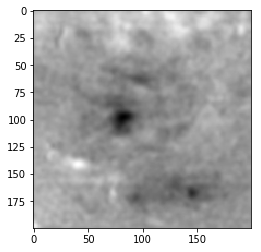

In [2]:
re_list = np.load('/home/kevinteng/Desktop/DeepLearning/Tensorflow2_0/test_npy/7-12-17-processed_dF.npy')
#re_list = np.load('test_npy/7-12-17-preprocessed.npy')
IMG_SIZE = re_list.shape[1]

#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

(200, 200, 1) float32


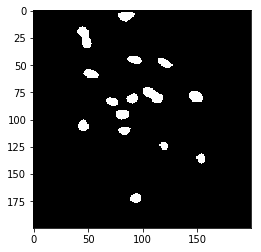

In [3]:
#retrieve and plot mean_ROI
mean_roi = np.load("/home/kevinteng/Desktop/mat/Ori_Lin/dg-13-7-12-17ROIs.mat_ROImask.npy")
mean_roi = cv2.resize(mean_roi, (200, 200))
#Dimension for network should include the color channel 
mean_roi = np.expand_dims(mean_roi, axis = -1)
#Cast data type to float32 for TensorFlow
mean_roi = mean_roi.astype('float32')

print(mean_roi.shape, mean_roi.dtype)
plt.imshow(np.squeeze(mean_roi), cmap = 'gray')

Shape:(200, 200, 1), Min:0, Max:1, Type:uint8
Number of detected ROIs: 15


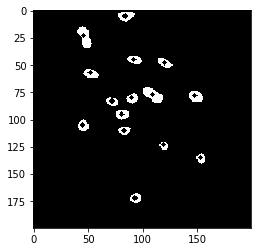

With centroids:
[(93, 172), (153, 135), (119, 123), (83, 110), (45, 105), (81, 95), (72, 83), (90, 80), (148, 78), (109, 77), (52, 57), (120, 48), (92, 45), (46, 23), (84, 5)]


In [4]:
centres, img_with_centroids  = utils.retrieve_centroid(mean_roi, centroid_rad = 2)

plt.imshow(np.squeeze(img_with_centroids), cmap = 'gray')
plt.show()
print('With centroids:')
print(centres)

In [5]:
#calculate mean image

mean_img_ori = utils.mean_image(re_list, IMG_SIZE)
#apply min max norm for mean image
mean_img_ori = utils.min_max_norm(mean_img_ori)
mean_img_ori = np.expand_dims(mean_img_ori, -1)
print('Max value:', np.max(mean_img_ori))
print('Min value:', np.min(mean_img_ori))


Max value: 1.0
Min value: 0.0


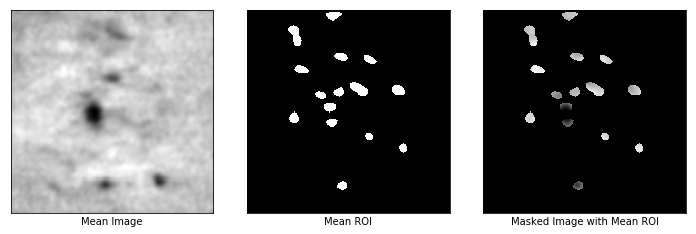

MSE:  0.5853560847720753
Dice coefficient:  0.05754157297837919


In [6]:
from utils import masked_img, dice_coef_py, MSE_image
from utils_vis import plot_comparison

captions = ['Mean Image', 'Mean ROI', 'Masked Image with Mean ROI']
plot_comparison([mean_img_ori, mean_roi,masked_img(mean_img_ori, mean_roi)], 
                captions, n_col =3, figsize = (10, 10))
print('MSE: ', MSE_image(np.squeeze(mean_img_ori), mean_roi, IMG_SIZE))
#measure IOU with dice coeff
print('Dice coefficient: ',dice_coef_py(mean_roi, mean_img_ori))

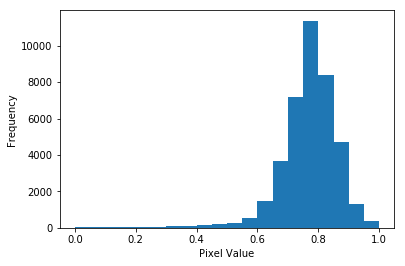

In [7]:
#plot historgram for mean image
plt.hist(mean_img_ori.ravel(),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Model

In [8]:
#hyperparameters 
BATCH_SIZE = 16
MAX_STEP = 2000 #exceeding 5000 steps will crash!
REPEAT = 1000
lr = 1e-3
data_augmentation = False

#Split data: 80% Training, 20% test
y_data = []
for i in range(len(re_list)):
    y_data.append(mean_roi)
    
y_data = np.asarray(y_data)
x_train, x_test, y_train, y_test = train_test_split(re_list, y_data, test_size = 0.2, random_state = 42)

#data generator
if data_augmentation:
    print('Augmented dataset!')
    BATCH_SIZE = 16 #system crash if batch size = 32 !
    ds_train = utils_model.data_aug(x_train, y_train, BATCH_SIZE)
else:
    ds_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).repeat(REPEAT).batch(BATCH_SIZE)

In [9]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block

l1_coeff = 0.99
#filters_layer = [16, 32, 64, 32, 16]
filters_layer = [32, 64]

#build network
def Coord_conv(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', kernel_regularizer = True, batch_norm = True,
                                   l1_coeff = l1_coeff)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = 1, kernel_size = 3, strides = 1, padding='same', 
                                       activation='sigmoid')
    return coordconv_03

def Convnet(input_layer):
    conv_01 = conv_block(input_layer, filters = filters_layer[0], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True) 
    conv_02 = conv_block(conv_01, filters = filters_layer[1], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu', kernel_regularizer = True,
                         batch_norm = True, l1_coeff = l1_coeff)
    conv_03 = conv_block(conv_02, filters = 1, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'sigmoid') 
    return conv_03

def Coord_conv02(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                   activation='relu', kernel_regularizer = True, l1_coeff = l1_coeff)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                   activation='relu', kernel_regularizer = True, l1_coeff = l1_coeff)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = filters_layer[2], kernel_size = 3, strides = 1, padding='same', 
                                   activation='relu', kernel_regularizer = True, l1_coeff = l1_coeff)
    coordconv_04 = coordconv_block(coordconv_03, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = filters_layer[3], kernel_size = 3, strides = 1, padding='same', 
                                   activation='relu', kernel_regularizer = True, l1_coeff = l1_coeff)
    coordconv_05 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                   activation='relu', batch_norm = True, kernel_regularizer = True,
                                   l1_coeff = l1_coeff)
    coordconv_06 = coordconv_block(coordconv_05, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = 1, kernel_size = 3, strides = 1, padding='same', 
                                   activation='sigmoid',kernel_regularizer = True, l1_coeff = l1_coeff)
    return coordconv_06
        
        

## Build Model

In [10]:
coordconv = True #toggle for coordconv and regular convnet
input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

if coordconv:
    print('The model is in Coordconv')
    model = Model(input_layer, Coord_conv(input_layer))
else:
    print('The model is in regular Conv-net')
    model = Model(input_layer, Convnet(input_layer))

The model is in Coordconv
L1 regularizer is activate!
L1 regularizer is activate!


-----------------------------------------------------------------

In [11]:
# dst = tf.data.Dataset.from_tensor_slices(re_list).repeat(2).batch(1)

# def ran_func(inp, stack, i, mean_roi):
#     if i!= 605 -1:
#         conv_img = model(inp) #value (0,1) because of sigmoid
#         stack+= tf.squeeze(conv_img)
#         mean_img = 0
#         loss = 0
#         #print('Mean is None!')
#         return loss, mean_img, stack
#     else: 
#         conv_img = model(inp) #value (0,1) because of sigmoid
#         stack+= tf.squeeze(conv_img)
#         mean_img = stack/(i+1)
#         mean_img = tf.expand_dims(mean_img, -1)
        
#         #print('Mean!')
#     loss = utils.MSE_image(mean_roi, mean_img, 200)    
#     return loss, mean_img,stack

# # one epochs is one training of one data session
# epochs = 0
# while epochs <2:
#     print("Epochs!:",epochs+1)
#     #initialize stack in every new epochs or new data session
#     stack = tf.zeros((200, 200))
#     #print(stack)
#     for i, (img) in enumerate(dst):
#         if i < 605:
#             loss, mean_img, stack =ran_func(img, stack, i, mean_roi)
#             if not i%4: 
#                 print(i)
#                 print("Loss!: {}, Mean!: {}".format(loss, mean_img))
#                 print(stack)
#                 print()
# #             if mean_img != 0:
# #                 print(i)
# #                 print(np.max(mean_img))
#             continue
#     print(loss)
#     epochs+=1

In [12]:
#sanity check
# utils.MSE_image(mean_roi, mean_img, 200)

In [13]:
# plt.imshow(np.squeeze(mean_img))

--------------------------------------------------------

## Train Model

In [14]:
from utils_model import img_mean, min_max_norm
#loss function
loss_fn = tf.losses.MeanSquaredError()
#loss_fn = lambda x,y: dice_coef_loss(x,y)
#loss_fn = lambda x,y: jaccard_distance_loss(x,y)

#annealer = lambda x: lr * 0.8 ** x
#optimizer 
opt = tf.optimizers.Adam(lr)

# max_step_num = int((len(re_list)*REPEAT)/BATCH_SIZE)
# print('Total number of steps: ',max_step_num)
# print()


dst = tf.data.Dataset.from_tensor_slices(re_list).repeat(5).batch(1)


@tf.function
def train(inp, mean_roi, stack, i):
    with tf.GradientTape() as tape:
        if i != 605 -1:
            if not i%100:
                print(i)
            conv_img = model(inp) #(batch, img_size, img_size)
            stack+= tf.squeeze(conv_img)
            mean_img = 0
            xent = 0
            return xent, mean_img, stack
        else:
            print(i)
            conv_img = model(inp) #value (0,1) because of sigmoid
            stack+= tf.squeeze(conv_img)
            mean_img = stack/(i+1)
            mean_img = tf.expand_dims(mean_img, -1)
            
        xent = loss_fn(mean_roi, mean_img)

    grads = tape.gradient(xent, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return xent, mean_img, stack

ori_list = [] #original image list
de_list = [] #mean image fromt the network list
loss_list = [] #loss list

epochs = 0

while epochs < 5:
    print('Epochs!:', epochs+1)
    #initialize stack in every new epochs or new data session
    stack = tf.zeros((200, 200))
    for step, (img_batch) in enumerate(dst):
        if step < 605:
            xent, conv_img, stack =train(img_batch, mean_roi, stack, step)
            continue
#         ori_list.append(img_batch)
    de_list.append(conv_img)
    loss_list.append(xent)

    print("Epochs {:2d}, Loss: {}".format(epochs, xent.numpy()))        
    epochs+=1

Epochs!: 1
0
100
200
300
400
500
600
604


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [ ]:
#plot for mean image of last 10 steps w.r.t mean roi 
for i in range(10):
    mean_image = de_list[len(de_list) - 10 + i]
    mean_image = np.asarray(mean_image) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    
    #plot
    inp_imgs = [mean_image , mean_roi, masked_image]
    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions,n_col = 3, figsize = (10,10))
    
    print('Loss:', loss_list[len(de_list) - 10 + i].numpy())
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))

In [ ]:
utils_vis.plot_loss(loss_list)

-------------------------------------------------

# Predict

In [ ]:
sums = 0
slices = 20 #slices of image from image stack 
n = 5

#create data generator for test set
ds_test = tf.data.Dataset.from_tensor_slices(x_test).shuffle(10000).repeat(REPEAT).batch(slices)

for i, (test_batch) in enumerate(ds_test):
    assert test_batch.shape[0] == slices

    conv_img = model(test_batch)
    mean_img = img_mean(conv_img, IMG_SIZE)
    mean_img = min_max_norm(mean_img)

    mean_image = np.asarray(mean_img) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    inp_imgs = [np.squeeze(mean_img), mean_roi, masked_image]

    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions, n_col = 3,figsize = (10,10))

    print('MSE for predicted image: ', MSE_image(mean_img, mean_roi, IMG_SIZE))
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))
    
    sums+=1
    
    #plot only n images for prediction
    if sums == n:
        break

-----------------------------------------------

# Visualizing Feature Maps

In [ ]:
from utils_vis import layers_dict, feature_maps, plot_feature_maps, layers_name

layer_dict = layers_dict(model)
layer_name = layers_name(model)

In [ ]:
if coordconv:
    layer_name = 'coord_conv'
else:
    layer_name = 'conv2d'
    
layer_output = layer_dict[layer_name].output

In [ ]:
# taking the mean over all stacks as input
test_img = np.asarray(tf.expand_dims(mean_img_ori, 0)) #(1, img size, img size, 1)
#test_img = tf.expand_dims(test_img, -1) #(1, img size, img size, 1)
plt.imshow(np.squeeze(test_img), cmap = 'gray')
plt.show()

## Visualizing Last Layer of Feature Maps

In [ ]:
test_map = feature_maps(model, '{}_1'.format(layer_name), test_img)
plot_feature_maps(test_map, 8, 8, figsize = (20,20))

## Visualizing First Layer of Feature Maps

In [ ]:
test_map02 = feature_maps(model, '{}'.format(layer_name), test_img)
plot_feature_maps(test_map02, 4, 8, figsize = (20,20))

--------------------------------

# Appendix

In [ ]:
#model.summary()